In [ ]:
pip install tensorflow pandas matplotlib scikit-learn opencv-python

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("images\labels.csv")

In [3]:
def load_data(csv_path, image_folder, img_size=(224, 224)):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].map({'normal': 0, 'abnormal': 1})

    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row['Filename'])
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, img_size)
            X.append(image)
            y.append(row['label'])

    X = np.array(X) / 255.0  # normalize
    y = np.array(y)
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Load data
X_train, X_val, y_train, y_val = load_data(
    csv_path='images/labels.csv',
    image_folder='images'
)

In [6]:
print(X_train.shape,X_val.shape)

(603, 224, 224, 3) (151, 224, 224, 3)


In [6]:
# Build a simple CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

c:\Users\mavikka\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("model/best_model.h5", save_best_only=True)
]

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5688 - loss: 2.5522

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5733 - loss: 2.4948 - val_accuracy: 0.6291 - val_loss: 0.6760
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8437 - loss: 0.3433

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8455 - loss: 0.3410 - val_accuracy: 0.8543 - val_loss: 0.3502
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9152 - loss: 0.1958 - val_accuracy: 0.8411 - val_loss: 0.3759
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 972ms/step - accuracy: 0.9412 - loss: 0.1400 - val_accuracy: 0.8344 - val_loss: 0.4552
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9642 - loss: 0.1126

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9644 - loss: 0.1119 - val_accuracy: 0.9007 - val_loss: 0.2932


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# Predictions
y_pred = model.predict(X_val).round()

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90        76
           1       0.91      0.89      0.90        75

    accuracy                           0.90       151
   macro avg       0.90      0.90      0.90       151
weighted avg       0.90      0.90      0.90       151

[[69  7]
 [ 8 67]]


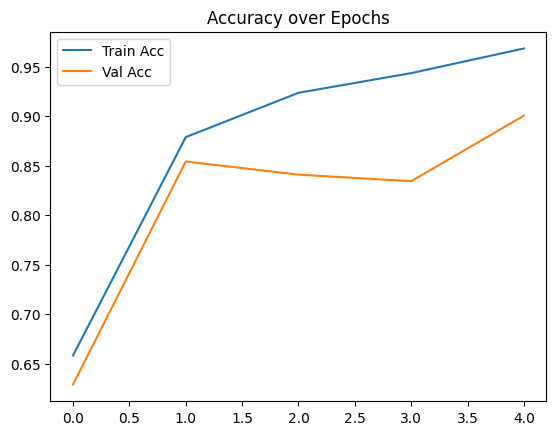

In [12]:
# Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()